##  Task description

 - Train VAE
 - Train vanilla AE to repeat VAE performance using GAN
 - Sample from AE, analyze sampling performance
 - Dataset: MNIST or similar dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

bs = 100
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
if torch.cuda.is_available():
    USE_CUDA = True
else:
    USE_CUDA = False

In [ ]:
USE_CUDA

True

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = nn.ReLU()(self.fc1(x))
        h = nn.ReLU()(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decoder(self, z):
        h = nn.ReLU()(self.fc4(z))
        h = nn.ReLU()(self.fc5(h))
        return nn.Sigmoid()(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if USE_CUDA:
    vae.cuda()

In [35]:
def loss_function(recon_x, x, mu, log_var):
    rec_loss = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 28 * 28))
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return rec_loss + kl_loss

In [36]:
len(train_loader)

600

In [ ]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if USE_CUDA:
    vae.cuda()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 30
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        if USE_CUDA:
            data = data.cuda()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset)}')

torch.save(vae.state_dict(), 'vae_mnist.pth')

Epoch 0, Average loss: 180.4328950032552
Epoch 1, Average loss: 158.18063142903645
Epoch 2, Average loss: 154.22131306966145
Epoch 3, Average loss: 151.45399931640625
Epoch 4, Average loss: 149.39072766927083
Epoch 5, Average loss: 147.6049080403646
Epoch 6, Average loss: 146.50380143229168
Epoch 7, Average loss: 145.52666583658853
Epoch 8, Average loss: 144.58902203776043
Epoch 9, Average loss: 143.87043313802084
Epoch 10, Average loss: 143.14427150065103
Epoch 11, Average loss: 142.84464653320313
Epoch 12, Average loss: 142.2847860514323
Epoch 13, Average loss: 141.72121606445313
Epoch 14, Average loss: 141.55156333007812
Epoch 15, Average loss: 141.13426547851563
Epoch 16, Average loss: 140.6175407389323
Epoch 17, Average loss: 140.4422204264323
Epoch 18, Average loss: 140.64276705729168
Epoch 19, Average loss: 140.7326407063802
Epoch 20, Average loss: 139.7510258951823
Epoch 21, Average loss: 139.8503718424479
Epoch 22, Average loss: 139.59241549479168
Epoch 23, Average loss: 139.0

In [ ]:
# !pip install torchvision
import torchvision

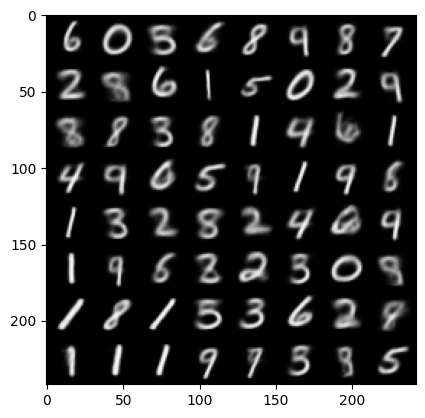

In [ ]:
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2)
    if USE_CUDA:
        z = z.cuda()
    sample = vae.decoder(z).view(64, 1, 28, 28)
    grid = torchvision.utils.make_grid(sample)
    plt.imshow(grid.cpu().permute(1, 2, 0))
    plt.show()

### Vanila AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VanillaAE(nn.Module):
    def __init__(self):
        super(VanillaAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 20),
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 784))
        x = self.decoder(x)
        return x

ae = VanillaAE()
if USE_CUDA:
    ae.cuda()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.BCELoss()

num_epochs = 20
ae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if USE_CUDA:
            data = data.cuda()
        optimizer.zero_grad()
        recon = ae(data)
        loss = criterion(recon, data.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset)}')

torch.save(ae.state_dict(), 'vanilla_ae_mnist.pth')

Epoch 0, Average loss: 0.0014776132080703973
Epoch 1, Average loss: 0.0009274920585254828
Epoch 2, Average loss: 0.0008140665058046579
Epoch 3, Average loss: 0.0007552198889354864
Epoch 4, Average loss: 0.0007213860273361206
Epoch 5, Average loss: 0.000698738656565547
Epoch 6, Average loss: 0.0006838625308126211
Epoch 7, Average loss: 0.0006733721067508062
Epoch 8, Average loss: 0.0006652199880530437
Epoch 9, Average loss: 0.000659176322321097
Epoch 10, Average loss: 0.0006544505013773838
Epoch 11, Average loss: 0.0006502335129926602
Epoch 12, Average loss: 0.0006464225605130196
Epoch 13, Average loss: 0.000643012444054087
Epoch 14, Average loss: 0.0006401017499466737
Epoch 15, Average loss: 0.0006374442235877116
Epoch 16, Average loss: 0.000635028126090765
Epoch 17, Average loss: 0.000633211853976051
Epoch 18, Average loss: 0.0006312298975884915
Epoch 19, Average loss: 0.0006295181203633547


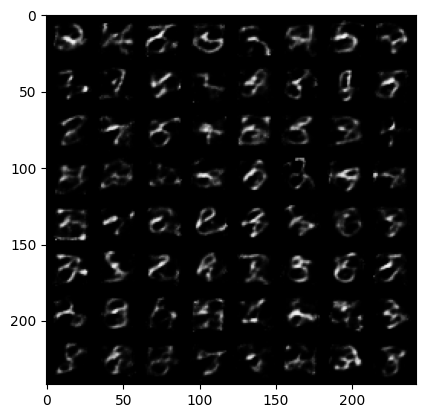

In [ ]:
num_epochs = 20
ae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if USE_CUDA:
            data = data.cuda()
        optimizer.zero_grad()
        recon = ae(data)
        loss = criterion(recon, data.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

ae.eval()
with torch.no_grad():
    z = torch.randn(64, 20)
    if USE_CUDA:
        z = z.cuda()
    sample = ae.decoder(z).view(64, 1, 28, 28)
    grid = torchvision.utils.make_grid(sample)
    plt.imshow(grid.cpu().permute(1, 2, 0))
    plt.show()

### Optimized with GAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, 784))

In [ ]:
critic = Discriminator()
critic.train()
ae.train()
vae.eval()

batch_size = 64
critic_steps = 3

lr = 0.0001
gen_optimizer = torch.optim.Adam(ae.parameters(), lr=lr, betas=(0, 0.9))
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

curr_iter = 0
d_loss, g_loss = torch.zeros(1), torch.zeros(1)
batch_loss_history = {"discriminator_losses": [], "generator_losses": []}
for epoch_i in tqdm(range(15000)):
    critic_optimizer.zero_grad()

    z = torch.randn(batch_size, 2)
    real_data = vae.decoder(z).view(batch_size, -1)

    z = torch.randn(batch_size, 20)
    fake_data = ae.decoder(z).view(batch_size, -1)

    d_loss = (critic(fake_data.detach()) - critic(real_data.detach())).mean()
    d_loss.backward()
    critic_optimizer.step()

    # generator update
    if curr_iter % critic_steps == 0:
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, 20)
        fake_data = ae.decoder(z).view(batch_size, -1)

        g_loss = -critic(fake_data).mean()

        g_loss.backward()
        gen_optimizer.step()

        batch_loss_history["generator_losses"].append(g_loss.data.cpu().numpy())
        batch_loss_history["discriminator_losses"].append(
            d_loss.data.cpu().numpy()
        )
    if epoch_i % 500 == 0:
        print("gen_loss:", batch_loss_history['generator_losses'][-1])
        print("dis_loss:", batch_loss_history['discriminator_losses'][-1])

  0%|          | 2/15000 [00:00<14:59, 16.67it/s]

gen_loss: -0.49849358
dis_loss: -0.0021930533


  3%|▎         | 505/15000 [00:19<11:07, 21.72it/s]

gen_loss: -0.26068836
dis_loss: -0.46063834


  7%|▋         | 1004/15000 [00:40<07:20, 31.76it/s]

gen_loss: -0.22212155
dis_loss: -0.597795


 10%|█         | 1504/15000 [00:59<09:03, 24.81it/s]

gen_loss: -0.07341662
dis_loss: -0.62182206


 13%|█▎        | 2006/15000 [01:20<08:08, 26.63it/s]

gen_loss: -0.02467591
dis_loss: -0.59764636


 17%|█▋        | 2506/15000 [01:41<07:11, 28.93it/s]

gen_loss: -0.051003437
dis_loss: -0.7875009


 20%|██        | 3003/15000 [01:59<10:31, 19.00it/s]

gen_loss: -0.10151675
dis_loss: -0.7502838


 23%|██▎       | 3504/15000 [02:18<06:13, 30.74it/s]

gen_loss: -0.046228223
dis_loss: -0.77992177


 27%|██▋       | 4007/15000 [02:37<05:51, 31.24it/s]

gen_loss: -0.0129118655
dis_loss: -0.7255967


 30%|███       | 4504/15000 [02:56<08:25, 20.76it/s]

gen_loss: -0.004266712
dis_loss: -0.73524255


 33%|███▎      | 5006/15000 [03:16<05:44, 28.97it/s]

gen_loss: -0.1603079
dis_loss: -0.8411491


 37%|███▋      | 5506/15000 [03:34<05:11, 30.44it/s]

gen_loss: -0.030533042
dis_loss: -0.81600076


 40%|████      | 6003/15000 [03:52<06:28, 23.16it/s]

gen_loss: -0.038948625
dis_loss: -0.82304496


 43%|████▎     | 6504/15000 [04:12<05:04, 27.95it/s]

gen_loss: -0.015562868
dis_loss: -0.861504


 47%|████▋     | 7004/15000 [04:31<04:38, 28.76it/s]

gen_loss: -0.004836672
dis_loss: -0.6779987


 50%|█████     | 7505/15000 [04:50<05:27, 22.91it/s]

gen_loss: -0.12922633
dis_loss: -0.8427008


 53%|█████▎    | 8006/15000 [05:09<03:56, 29.54it/s]

gen_loss: -0.07077341
dis_loss: -0.81210274


 57%|█████▋    | 8504/15000 [05:28<03:38, 29.69it/s]

gen_loss: -0.040895738
dis_loss: -0.84983045


 60%|██████    | 9004/15000 [05:47<04:49, 20.70it/s]

gen_loss: -0.08046959
dis_loss: -0.8333704


 63%|██████▎   | 9505/15000 [06:07<03:16, 27.93it/s]

gen_loss: -0.016432535
dis_loss: -0.8889407


 67%|██████▋   | 10006/15000 [06:26<02:56, 28.22it/s]

gen_loss: -0.027295265
dis_loss: -0.77054626


 70%|███████   | 10503/15000 [06:45<03:51, 19.43it/s]

gen_loss: -0.17512938
dis_loss: -0.78211725


 73%|███████▎  | 11006/15000 [07:05<02:18, 28.90it/s]

gen_loss: -0.10167179
dis_loss: -0.7769034


 77%|███████▋  | 11505/15000 [07:24<02:01, 28.86it/s]

gen_loss: -0.096716166
dis_loss: -0.8118711


 80%|████████  | 12004/15000 [07:43<02:38, 18.90it/s]

gen_loss: -0.06823252
dis_loss: -0.91774374


 83%|████████▎ | 12504/15000 [08:03<01:31, 27.37it/s]

gen_loss: -0.024531817
dis_loss: -0.8455244


 87%|████████▋ | 13004/15000 [08:22<01:12, 27.50it/s]

gen_loss: -0.14167303
dis_loss: -0.6947417


 90%|█████████ | 13504/15000 [08:43<00:53, 27.79it/s]

gen_loss: -0.02542982
dis_loss: -0.6738091


 93%|█████████▎| 14006/15000 [09:03<00:38, 25.76it/s]

gen_loss: -0.009048156
dis_loss: -0.78196836


 97%|█████████▋| 14504/15000 [09:24<00:25, 19.24it/s]

gen_loss: -0.14337468
dis_loss: -0.7559754


100%|██████████| 15000/15000 [09:43<00:00, 25.72it/s]


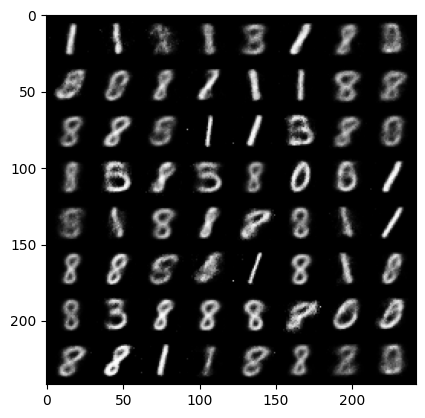

In [ ]:
ae.eval()
with torch.no_grad():
    z = torch.randn(64, 20)
    sample = ae.decoder(z).view(64, 1, 28, 28)
    grid = torchvision.utils.make_grid(sample)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

Как видим, произошёл mode collapse

In [ ]:
import numpy as np

def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

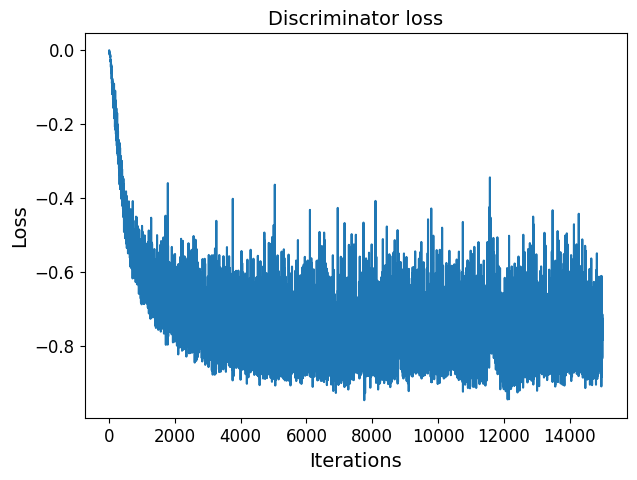

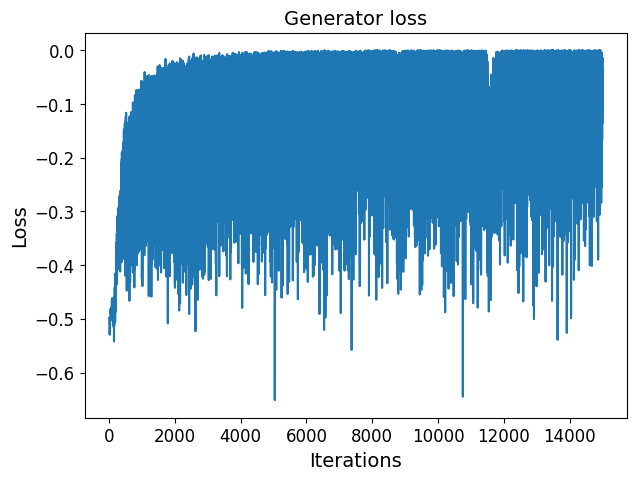

In [ ]:
plot_losses(batch_loss_history["discriminator_losses"], "Discriminator loss")
plot_losses(batch_loss_history["generator_losses"], "Generator loss")

### Переписывание кода на Jax

Спойлер: почему-то ничего не обучилось

In [ ]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([
    transforms.ToTensor(),
])

bs = 100
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [14]:
from jax.example_libraries import optimizers
import time
import numpy as np
from jax import grad, jit, vmap, value_and_grad

In [75]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax import random

class Encoder(nn.Module):
    h_dim1: int
    h_dim2: int
    z_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.h_dim1)(x)
        x = nn.relu(x)
        x = nn.Dense(self.h_dim2)(x)
        x = nn.relu(x)
        mean = nn.Dense(self.z_dim)(x)
        log_var = nn.Dense(self.z_dim)(x)
        return mean, log_var

class Decoder(nn.Module):
    h_dim1: int
    h_dim2: int
    x_dim: int

    @nn.compact
    def __call__(self, z):
        z = nn.Dense(self.h_dim2)(z)
        z = nn.relu(z)
        z = nn.Dense(self.h_dim1)(z)
        z = nn.relu(z)
        z = nn.Dense(self.x_dim)(z)
        return nn.sigmoid(z)

class VAE(nn.Module):
    x_dim: int
    h_dim1: int
    h_dim2: int
    z_dim: int

    def setup(self):
        self.encoder = Encoder(self.h_dim1, self.h_dim2, self.z_dim)
        self.decoder = Decoder(self.h_dim1, self.h_dim2, self.x_dim)

    def __call__(self, x):
        mean, log_var = self.encoder(x)
        std = jnp.exp(0.5 * log_var)
        eps = random.normal(jax.random.PRNGKey(0), log_var.shape)
        z = eps * std + mean
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

    def encode(self, x):
        assert x.shape[1:] == self.input_shape
        x = jnp.reshape(x, (x.shape[0], -1))
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

vae = VAE(784, 512, 256, 2)
params = vae.init(random.PRNGKey(0), jnp.ones((1, 784)))

In [76]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [86]:
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from flax.training import train_state
import optax

def loss_function(params, recon_x, x, mu, log_var):
    bce = optax.sigmoid_binary_cross_entropy(recon_x, jnp.reshape(x, (-1, 28 * 28))).sum()
    kld = -0.5 * jnp.sum(1 + log_var - jnp.square(mu) - jnp.exp(log_var))
    return bce + kld

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    recon_x, mu, log_var = vae.apply(params, x)
    value, grads = value_and_grad(loss_function)(params, recon_x, x, mu, log_var)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [72]:
def run_mnist_training_loop(num_epochs, opt_state):
    """ Implements a learning loop over epochs. """
    train_loss, train_loss_kl = [], []
    params = get_params(opt_state)
    print("Start training")
    for epoch in range(num_epochs):
        for data, target in train_loader:
            x = np.array(data).reshape(data.size(0), 28 * 28)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, kl_loss = update(params, x, y, opt_state)
            train_loss_kl.append(kl_loss)
        print(f"Epoch {epoch+1}, Elbo loss: {np.mean(train_loss_kl)}")
    return opt_state, train_loss_kl

In [87]:
vae = VAE(784, 512, 256, 2)
vae_params = vae.init(random.PRNGKey(0), jnp.ones((1, 784)))

step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(vae_params)
vae_params = get_params(opt_state)
num_epochs = 10
num_classes = 10
train_loss_kl = []

print("Start training")
for epoch in range(num_epochs):
    for data, target in train_loader:
        x = np.array(data).reshape(data.size(0), 28 * 28)
        y = one_hot(np.array(target), num_classes)
        vae_params, opt_state, kl_loss = update(vae_params, x, y, opt_state)
        train_loss_kl.append(kl_loss)
    print(f"Epoch {epoch+1}, Elbo loss: {np.mean(train_loss_kl)}")

trained_params = get_params(opt_state)

Start training
Epoch 1, Elbo loss: 71275.7421875
Epoch 2, Elbo loss: 71275.671875
Epoch 3, Elbo loss: 71275.6015625
Epoch 4, Elbo loss: 71275.6015625
Epoch 5, Elbo loss: 71275.640625
Epoch 6, Elbo loss: 71275.703125
Epoch 7, Elbo loss: 71275.71875
Epoch 8, Elbo loss: 71275.7265625
Epoch 9, Elbo loss: 71275.765625
Epoch 10, Elbo loss: 71275.7578125


In [67]:
def generate_samples_from_vae(vae_model, decoder_params, key, num_samples=1, z_dim=2):
    z = random.normal(key, (num_samples, z_dim))
    decoded_samples = vae_model.apply({'params': {'decoder': decoder_params}}, z, method=VAE.decode)
    return decoded_samples

key = random.PRNGKey(0)
z_dim = 2
num_samples = 10
decoder_params = vae_params['params']['decoder']
samples = generate_samples_from_vae(vae, decoder_params, key, num_samples, z_dim=z_dim)

In [68]:
def plot_samples(samples):
    fig, axs = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

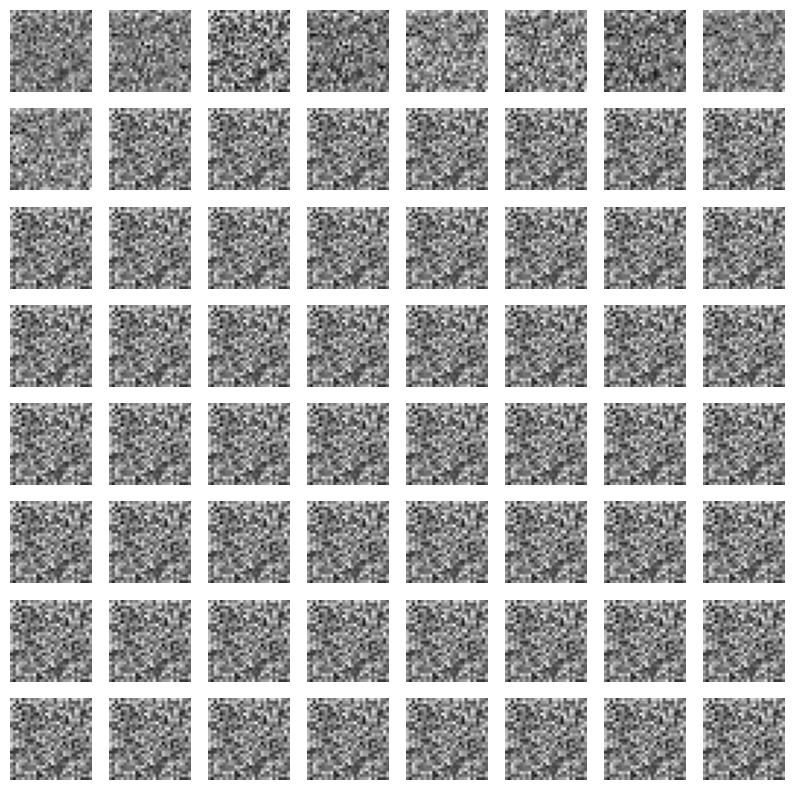

In [69]:
plot_samples(samples)

### AE on JAX

In [39]:
from flax import linen as nn
import jax.numpy as jnp
import numpy as np
from jax import random, grad, jit
import optax

class AE_Encoder(nn.Module):
    def setup(self):
        self.fc1 = nn.Dense(512)
        self.fc2 = nn.Dense(256)
        self.fc3 = nn.Dense(20)

    def __call__(self, x):
        x = nn.relu(self.fc1(x))
        x = nn.relu(self.fc2(x))
        return self.fc3(x)

class AE_Decoder(nn.Module):
    def setup(self):
        self.fc1 = nn.Dense(256)
        self.fc2 = nn.Dense(512)
        self.fc3 = nn.Dense(784)

    def __call__(self, z):
        z = nn.relu(self.fc1(z))
        z = nn.relu(self.fc2(z))
        return nn.sigmoid(self.fc3(z))


In [40]:
class VanillaAE(nn.Module):
    def setup(self):
        self.encoder = AE_Encoder()
        self.decoder = AE_Decoder()

    def __call__(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def encode(self, x):
        assert x.shape[1:] == self.input_shape
        x = jnp.reshape(x, (x.shape[0], -1))
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [42]:
def mse_loss(params, model, x):
    recon_x = model.apply({'params': params}, x)
    return jnp.mean((recon_x - x) ** 2)

@jit
def update(params, x, opt_state):
    value, grads = value_and_grad(mse_loss)(params, ae_model, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

ae_model = VanillaAE()

step_size = 3e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
ae_params = ae_model.init(jax.random.PRNGKey(0), jnp.ones((1, 28 * 28)))['params']
opt_state = opt_init(ae_params)

num_epochs = 20
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        x = jnp.array(data).reshape(data.size(0), 28 * 28)
        ae_params, opt_state, loss_value = update(ae_params, x, opt_state)
        train_loss += loss_value
    print(f'Epoch {epoch}, Average loss: {train_loss}')

Epoch 0, Average loss: 22.45792579650879
Epoch 1, Average loss: 12.400343894958496
Epoch 2, Average loss: 10.803675651550293
Epoch 3, Average loss: 9.901302337646484
Epoch 4, Average loss: 9.304594993591309
Epoch 5, Average loss: 8.824152946472168
Epoch 6, Average loss: 8.489617347717285
Epoch 7, Average loss: 8.21694278717041
Epoch 8, Average loss: 7.97150993347168
Epoch 9, Average loss: 7.7512664794921875
Epoch 10, Average loss: 7.552486419677734
Epoch 11, Average loss: 7.3617329597473145
Epoch 12, Average loss: 7.203493118286133
Epoch 13, Average loss: 7.074230194091797
Epoch 14, Average loss: 6.935863018035889
Epoch 15, Average loss: 6.777522087097168
Epoch 16, Average loss: 6.600959777832031
Epoch 17, Average loss: 6.481254577636719
Epoch 18, Average loss: 6.35465145111084
Epoch 19, Average loss: 6.262217044830322


In [43]:
def generate_samples_from_ae(ae_model, ae_params, key, num_samples=1, z_dim=20):
    z = random.normal(key, (num_samples, z_dim))
    decoded_samples = ae_model.apply({'params': ae_params}, z, method=VanillaAE.decode)
    return decoded_samples

key = random.PRNGKey(0)
num_samples = 10
z_dim = 20
samples = generate_samples_from_ae(ae_model, ae_params, key, num_samples, z_dim=z_dim)

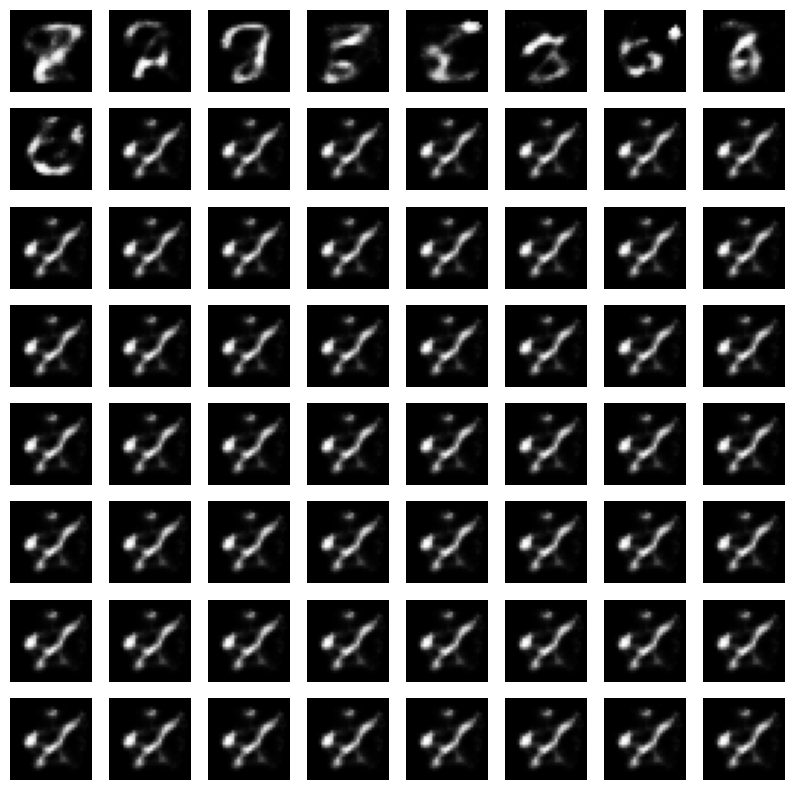

In [32]:
plot_samples(samples)